# Homework 12 on SQL and Semi-Variogram

### Student: Le Xu
### ID: lx565

In [447]:
import ast
from scipy.spatial.distance import pdist, squareform
from geostatsmodels import utilities, kriging, variograms, model, geoplot
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.colors as mcolors
import scipy.stats as stats
from geopandas import GeoDataFrame

%matplotlib inline
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'



In [448]:
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [449]:
facilityQuery = '''

SELECT nycasthmasdismissals.zipcodes, COUNT(nycasthmasdismissals.cartodb_id)
FROM NYCAsthmasDismissals 
GROUP BY nycasthmasdismissals.zipcodes


'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


In [450]:
nyc_shape = GeoDataFrame.from_file("ZIP_CODE_040114.shp")

In [451]:
nyc_shape["centers"] = nyc_shape.geometry.centroid

In [452]:
nyc_shape = nyc_shape.rename(columns={"ZIPCODE": "zipcodes"})

In [453]:
nyc_shape.head()

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,zipcodes,geometry,centers
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",POINT (1040696.262135346 185580.2219140405)
1,2.963100e+07,0,Kings,047,62426.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",POINT (1001912.871996466 183803.1131420481)
2,4.197210e+07,0,Kings,047,83866.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",POINT (1008365.375095716 180768.9448568909)
3,2.369863e+07,0,Kings,047,56527.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",POINT (997023.1926918941 180870.3533200975)
4,3.686880e+07,0,Kings,047,72280.0,Brooklyn,0.0,0.0,NY,36,http://www.usps.com/,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",POINT (990785.2911208535 173656.048379133)


In [454]:
nyc_shape.zipcodes = nyc_shape.zipcodes.astype(int)

In [455]:
merged = facilities.merge(nyc_shape[["zipcodes", "centers"]], on = "zipcodes", how = "inner")

In [456]:
merged

,count,zipcodes,centers
0,1699,10461,POINT (1028292.72437689 247902.4282787614)
1,405,11373,POINT (1017941.215480481 208485.1046661779)
2,1698,10451,POINT (1005358.961284301 238316.0675161843)
3,220,11691,POINT (1050360.772370908 158235.4624321515)
4,246,11375,POINT (1026858.206454871 201880.2234817908)
5,494,10466,POINT (1026647.114925691 263909.2896452093)
6,713,11212,POINT (1008365.375095716 180768.9448568909)
7,167,11229,POINT (999714.2819237487 158289.3193893406)
8,521,11215,POINT (989857.1615907477 181769.9626017534)
9,386,11220,POINT (979603.6885367428 172876.8181350912)


---

In [457]:
nyc_shape = nyc_shape.to_crs(epsg=32118)   # change to meter for epsg
nyc_shape["centers"] = nyc_shape.geometry.centroid
nyc_shape = nyc_shape.rename(columns={"ZIPCODE": "zipcodes"})
nyc_shape.zipcodes = nyc_shape.zipcodes.astype(int)
merged = facilities.merge(nyc_shape[["zipcodes", "centers"]], on = "zipcodes", how = "inner")

In [458]:
merged_meter = merged
merged_meter

,count,zipcodes,centers
0,1699,10461,POINT (313424.2492385741 75560.81126467438)
1,405,11373,POINT (310269.1030166565 63546.38699871019)
2,1698,10451,POINT (306434.0242675035 72638.88266038381)
3,220,11691,POINT (320150.6037198587 48230.26541353501)
4,246,11375,POINT (312987.0073014589 61533.21518736531)
5,494,10466,POINT (312922.6664746841 80439.71236697005)
6,713,11212,POINT (307350.3810299358 55098.4845930345)
7,167,11229,POINT (304713.5225574032 48246.68104691816)
8,521,11215,POINT (301709.0662709916 55403.59541189024)
9,386,11220,POINT (298583.8014336014 52692.95955717975)


# Create a 3xN numpy array with x-location, y-location, number of dismissals

In [459]:
#merged.centers 
def getXY(pt):
    return [pt.x, pt.y]
centroidseries = merged_meter['centers']
centroidlist = map(getXY, centroidseries)
centroidlist = np.array(centroidlist)

In [460]:
krigdata = np.zeros((len(merged_meter),3))

In [461]:
krigdata[:,0] = centroidlist[:,0]
krigdata[:,1] = centroidlist[:,1]
krigdata[:,2] = merged_meter["count"]

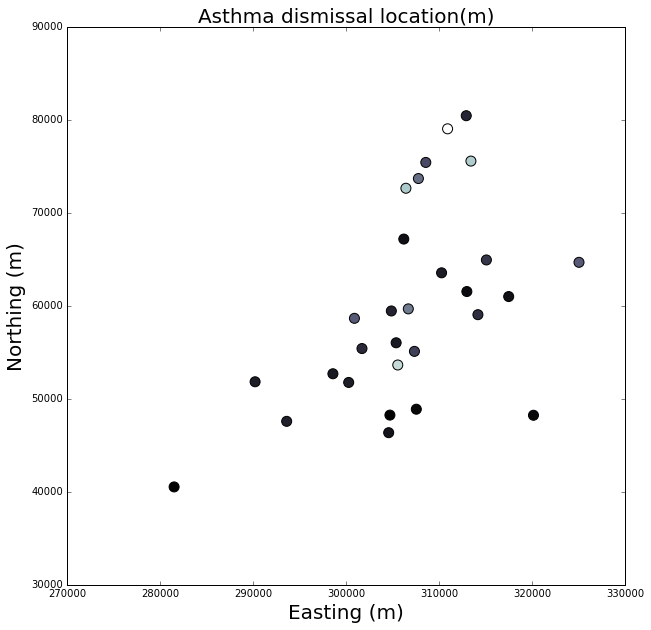

In [496]:
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title("Asthma dismissal location(m)", fontsize=20)

Calculate the max euclidean distance

In [542]:
a = (280000,40000)
b = (325000,65000)
dist = distance.euclidean(a,b)
dist

51478.150704935004

## Create Semi-Variogram

In [552]:
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [553]:
mysv = SV( x, np.arange(1, dist, 500), 500)

In [554]:
# different variogram models
def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

    
def gaussianngt(h, a, C0):
    #print "gaus"
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( gaussianngt, h, a, C0 )




def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct

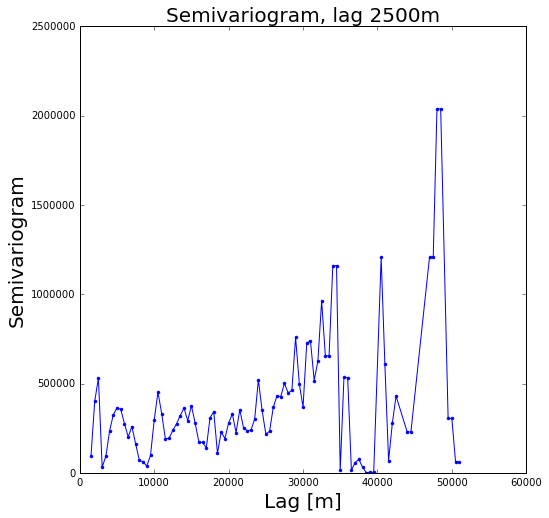

In [555]:
# lags in 500 meter increments from zero to 100,000
bw = 500
hs = np.arange(0, 50000, 500)

pl.figure(figsize=(8,8))
sv = SV( P, hs, bw )
pl.plot( mysv[0], mysv[1], '.-' )
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Semivariogram, lag %dm'%lag, fontsize=20) 

## Figure Caption: Semivariogram of Asthma dismissal records

In [556]:
def spherical( h, a, C0 ):
    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )


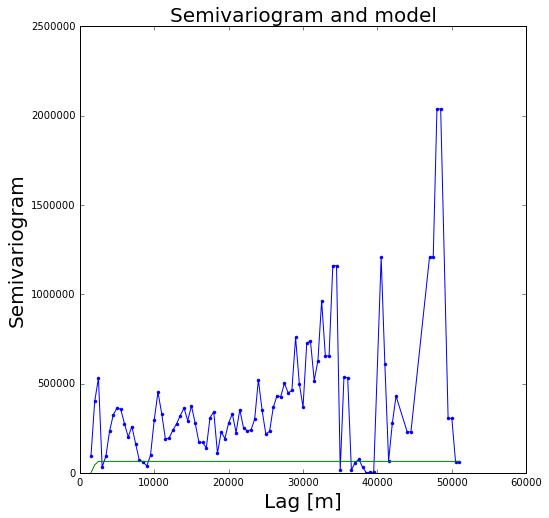

In [560]:
bw = 500
pl.figure(figsize=(8,8))
sp = cvmodel( x, model=spherical, 
             hs = np.arange(0, 50000, 500), bw=bw)
#print sp(mysv[0])
sphere = sp(mysv[0])
pl.plot( mysv[0], mysv[1], '.-' )
pl.plot(mysv[0], -sphere+sphere.max())
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Semivariogram and model', fontsize=20) ;


## Figure Caption: Semivariogram and Spherical Model of Asthma dismissal records

## Thoughts : The plot of semivariogram and model is not fitting so well. It seems to me, the further point sometimes is more similiar than the closer point to a certain area. It could be due to not enough samples(s< 30), or the hospital's zipcode of the dismissal records does not necessarily represent where the Asthma patient lives. 

---

### Let's SEE that our data is distributed normally.

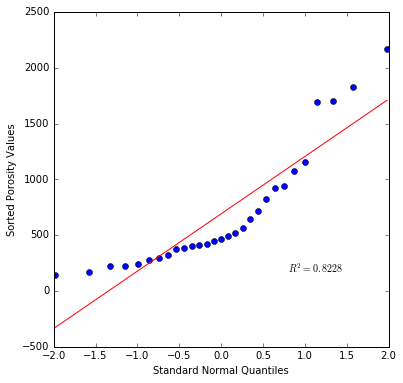

In [503]:
qqdata = stats.probplot(krigdata[:,2], dist="norm",plot=pl,fit=False, rvalue= True)
xh=pl.xlabel('Standard Normal Quantiles')
yh=pl.ylabel('Sorted Porosity Values')
fig=pl.gcf()
fig.set_size_inches(6,6)
th=pl.title('')

   ## The R2 value looks okay, but we definitely need more data to see if it is normally distributed.  

----

# Use Geostatsmodel 

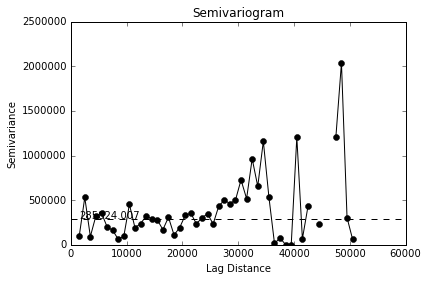

In [523]:
tolerance = 500
lags = np.arange( tolerance, 100000, tolerance*2 )
sill = np.var(krigdata[:,2])
P = krigdata
geoplot.semivariogram( P, lags, tolerance )

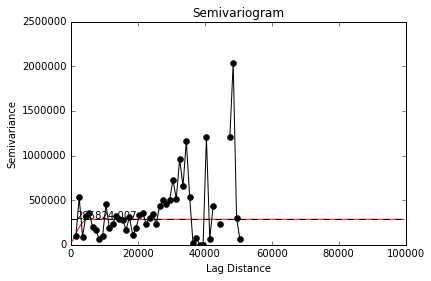

In [539]:
svm = model.semivariance( model.spherical, [ 5000, sill ] )
geoplot.semivariogram( P, lags, tolerance, model=svm )

## The result obtained from the geostatsmodel package is smiliar to what we got from the previous practice. The semivariogram is too wavy, it is hard to make conclusion that Asthma occurence has geospatial pattern. 